![Logo de AA1](logo_AA1_texto_small.png) 
# Sesión 23 - Problemas de Regresión: métricas y regresión lineal

A lo largo de la asignatura hemos estado introduciendo conceptos y algoritmos de aprendizaje automático apoyándonos en problemas de clasificación.

En esta sesión vamos a introducir otro tipo de problemas, los de regresión, que son problemas en los que en lugar de predecir una categoría debemos predecir un valor continuo.

Lo primero que vamos a hacer es plantear un problema muy sencillo en el que los ejemplos vendrán definidos por un solo atributo y nuestro objetivo será tratar de predecir el valor $y$ correspondiente:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

print('\n##########################################')
print('### Crear conjunto')
print('##########################################')

# definimos la función verdadera, a partir de la cual crearemos los conjuntos
def fun(X):
    return np.cos(1.5 * np.pi * X)

# definimos el número de ejemplos del conjunto de entrenamiento y de test
num_ejemplos_train = 30
num_ejemplos_test = 100

# fijamos semilla de aletorios
np.random.seed(1234)

# creamos valores de X aleatorios para train
X_train = np.sort(np.random.rand(num_ejemplos_train))

# calculamos los valores de y añadiendo un poco de ruido
y_train = fun(X_train) + np.random.randn(num_ejemplos_train) * 0.3

# creamos un conjunto de test con num_ejemplos_test ejemplos a igual distancia unos de otros en el intervalo de 0 a 1
X_test = np.linspace(0, 1, num_ejemplos_test)

# calculamos su valor correcto
y_test = fun(X_test)


##########################################
### Crear conjunto
##########################################


En el trozo de código anterior se define un conjunto de datos que sigue la función $y=cos(1.5\pi x)$, estando los ejemplos representados por un único atributo.

Para dificultar un poco el aprendizaje, a la hora de calcular `y_train` incorporamos un poco de ruido. 

Vamos a representar los datos del conjunto de entrenamiento de forma gráfica acompañados de la función verdadera:


##########################################
### Representamos los datos
##########################################


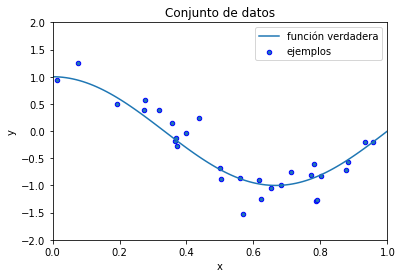

In [3]:
print('\n##########################################')
print('### Representamos los datos')
print('##########################################')

# represento la función verdadera, los ejemplos de entrenamiento y la predicción del modelo
fig, ax = plt.subplots()
ax.plot(X_test, fun(X_test), label="función verdadera")
ax.scatter(X_train, y_train, edgecolor="b", s=20, label="ejemplos")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim((0, 1))
ax.set_ylim((-2, 2))
ax.legend(loc="best")
ax.set_title("Conjunto de datos")
plt.show()

Como podemos apreciar, el ruido que hemos incorporado a los datos provoca que los ejemplos no se ajusten prefectamente a la función.

## 23.1 Baselines de regresión

Al igual que sucedía con los problemas de clasificación, es importante tener algún predictor sencillo que sirva para marcar un umbral a partir del cual, rendimientos superiores indiquen que los sistemas están realmente aprendiendo algo.

En el caso de la regresión, un baseline sencillo es el *sistema media*, que consiste en calcular el valor medio de $y$ en el conjunto de entrenamiento y utilizarlo como valor constante a predecir para todos los ejemplos del conjunto de test. Esto es precisamente lo que hace `DummyRegressor` cuando utilizamos como estrategia `strategy="mean"`.

In [4]:
print('\n##########################################')
print('### DummyRegressor')
print('##########################################')

# se crea el sistema que siempre predice la media
sys_dummy = DummyRegressor(strategy="mean")

# se entrena con el conjunto de entrenamiento (reshape es para darle ponerlo en forma (num_ejemplos_train,1))
sys_dummy.fit(X_train.reshape(-1,1), y_train)

# se evalúa sobre el conjunto de test (reshape es para darle ponerlo en forma (num_ejemplos_test,1))
y_pred = sys_dummy.predict(X_test.reshape(-1,1))


##########################################
### DummyRegressor
##########################################


Hemos tenido que utilizar `reshape(-1,1)` ya que `X_train` es un vector $(n,)$ y queremos convertirlo a una matriz $(n,1)$.

Como vemos en el código, la manera de entrenar y predecir es igual que en los problemas de clasificación.

En https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html?highlight=dummyregressos#sklearn.dummy.DummyRegressor.score se pueden encontrar más detalles acerca del sistema `DummyRegressor`.

Admite las estrategias:
- `mean`, predice la media calculada en el conjunto de entrenamiento.
- `median`, predice la mediana calculada en el conjunto de entrenamiento.
- `quantile`, predice el cuantil especificado del conjunto de entrenamiento. Debe especificarse en el parámetro `quantile` que debe ser un valor en el rango [0.0, 1.0].
- `constant`, predice un valor constante que debe suministrarse en el parámetro `constant`.

Vamos a representar gráficamente la solución propuesta por el `DummyRegressor` entrenado:


##########################################
### Representación gráfica
##########################################


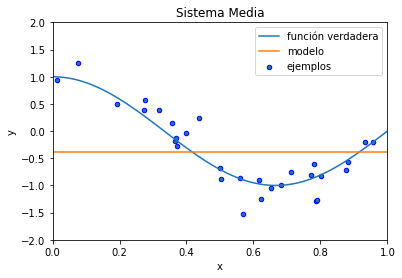

In [5]:
print('\n##########################################')
print('### Representación gráfica')
print('##########################################')

# represento la función verdadera, los ejemplos de entrenamiento y la predicción del modelo
fig, ax = plt.subplots()
ax.plot(X_test, fun(X_test), label="función verdadera")
ax.plot(X_test, y_pred, label="modelo")
ax.scatter(X_train, y_train, edgecolor="b", s=20, label="ejemplos")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim((0, 1))
ax.set_ylim((-2, 2))
ax.legend(loc="best")
ax.set_title("Sistema Media")
plt.show()

A la vista de la representación obtenida para el modelo `DummyRegressor` no parece que el rendimiento que se vaya a obtener sea demasiado bueno ya que, independientemente del valor de $x$, el valor predicho para la $y$ será siempre el mismo valor (en este caso la media calculada en el conjunto de entrenamiento).

Vamos a ver cómo medirlo.

## 23.2 Métricas utilizadas en regresión

En los problemas de regresión la clase es de tipo continuo y por tanto debemos utilizar métricas que sean capaces trabajar con este tipo de valores.

Hay muchas métricas para problemas de regresión (https://scikit-learn.org/stable/modules/model_evaluation.html), pero nosotros vamos a comentar las tres más utilizadas.

### 23.2.1 Error Absoluto medio

Esta es la métrica más sencilla e intuitiva. 

Definimos el **Error Abdoluto Medio**, conocido habitualmente como *Mean Absolute Error (MAE)* como:

$$
MAE(y,\hat{y}) = \frac{1}{n}\sum^n_{i=1}\left|y_i - \hat{y}_i\right|
$$

donde $n$ es el número de ejemplos, $\hat{y}_i$ es el valor predicho para el i-ésimo ejemplo e $y_i$ es su valor verdadero.

Así que esta métrica lo que nos muestra es el error medio que se está comentiendo en todos los ejemplos. Así que una predicción perfecta tendrá un MAE de 0 y predicciones imperfectas tendrán valores mayores que 0 sin tener un límite superior. El MAE no puede ser negativo.

Vamos a ver qué MAE tenemos para el `DummyRegressor` con el que obtuvimos `y_pred` anteriormente:


In [6]:
# se calcula el error absoluto medio
mae = metrics.mean_absolute_error(y_test, y_pred)
print("MAE = %.3f" % mae )

MAE = 0.575



El MAE penaliza por igual errores grandes y errores pequeños. Por ejemplo, si cometemos dos fallos, errando en uno por 2 unidades y en el otro por 6 unidades, el MAE será 4 ($\frac{2+6}{2}$); si esos dos fallos hubiesen sido dos errores de 4 unidades el MAE sería el mismo ($\frac{4+4}{2}$).

¿Cuál de las dos situaciones es mejor? En principio eso depende del problema que estemos abordando, pero en general, siempre suele ser deseable penalizar más a los sistemas que cometen errores muy grandes.

### 23.2.2 Error Cuadrático Medio

Para solucionar el problema que hemos visto en el MAE, podemos elevar al cuadrado los errores y así se penalizará mucho más a los errores más grandes.

Para ello, definimos el **Error Cuadrático Medio**, conocido habitualmente como *Mean Squared Error (MSE)*, como:

$$
MSE(y,\hat{y}) = \frac{1}{n}\sum^n_{i=1}\left(y_i - \hat{y}_i\right)^2
$$

Al igual que sucedía con el MAE, con el error cuadrático medio, una predicción perfecta tendrá un MSE de 0 y predicciones imperfectas tendrán valores mayores que 0 sin tener un límite superior. El MSE no puede ser negativo.

El error cuadrático medio **es la métrica más utilizada en los problemas de regresión**.

Para las dos situaciones que comentamos antes obtendríamos como MSE $20=\left(\frac{2^2+6^2}{2}\right)$ y $16=\left(\frac{4^2+4^2}{2}\right)$.

Vamos a ver qué MSE tenemos para el `DummyRegressor` con el que obtuvimos `y_pred` anteriormente:

In [7]:
# se calcula el error cuadrático medio
mse = metrics.mean_squared_error(y_test, y_pred)
print("MSE = %.3f" % mse )

MSE = 0.490


Los valores que obtenemos tanto para MSE como para MAE, sabemos que son mejores cuanto más nos acercamos al 0, pero es complicado saber cuánto de mala es una predicción ya que no están acotadas superiormente.

### 23.2.3 Coeficiente de determinación

Una métrica que nos puede ayuda en esto es **Coeficiente de Determinación**, que se define como (https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score):

$$
R^2(y,\hat{y}) = 1 - \frac{\sum^n_{i=1}\left(y_i - \hat{y}_i\right)^2}{\sum^n_{i=1}\left(y_i - \bar{y}_i\right)^2}
$$

donde $\bar{y}=\frac{1}{n}\sum^n_{i=1} y_i$, es decir, es la media de los valores de la clase que tienen los ejemplos **del conjunto de datos que se evalúa**.

El coeficiente de determinación calcula la proporción de variación de la clase $y$ que es explicada por la predicción $\hat{y}$.

Con lo que:
- una predicción perfecta tendrá un $R^2$ de 1, 
- malas predicciones podrán tener valores negativos 
- una predicción constante igual al valor medio de la $y$ de los ejemplos evaluados tendrá un $R^2$ igual a 0. Cuando utilizamos `DummyRegressor(strategy="mean")` podemos pensar que $R^2$ debe ser igual a $0$, por lo que acabamos de explicar, pero no tiene por qué ser así. El sistema media calcula la media de los valores de $y$ **del conjunto de entrenamiento** y la media que interviene en el cálculo del coeficiente de determinación es la media de los valores de $y$ **en el conjunto que se evalúa**. 

Si tenemos un $R^2$ negativo el resultado es muy malo. Si es en torno al 0, es el equivalente a lo que haría el sistema media y si obtenemos un $R^2$ entre 0 y 1 nuestro sistema habrá aprendido algo útil, que será más útil cuanto más nos acerquemos al 1.

Veamos el resultado que obtenemos:

In [8]:
# se calcula el coeficiente de determinación
r2 = metrics.r2_score(y_test, y_pred)
print("R2 = %.3f" % r2 )

R2 = -0.071


Vemos que el resultado es próximo al 0, lo cual era esperable ya que estamos utilizando el sistema media. El resultado no es exactamente 0 porque la media de los valores de $y$ en el conjunto de entrenamiento no es exactamente igual a la media de los valores de $y$ en el conjunto de test.

## 23.3 Negative scoring y `KFold`

Las métricas que hemos visto en clasificación eran todas métricas en las que cuanto mayor fuese el valor que obteníamos mejor era el rendimiento del sistema.

En $R^2$ esto es también así, pero en MAE y MSE sucede al contrario.

Como la mayoría de las métricas están orientadas a que mayores valores supongan mejor rendimiento, los procedimientos dentro de `scikit-learn` que tratan de optimizar el rendimiento, como por ejemplo `GridSearchCV()`, tratan de maximizar la métrica que se les indica en el parámetro `scoring`.

Por tanto, si queremos utilizar MAE o MSE como `scoring` en alguna función de `sklearn`, debemos utilizar sus versiones "negadas": `'neg_mean_absolute_error'` y `'neg_mean_squared_error'`.

En el enlace https://scikit-learn.org/stable/modules/model_evaluation.html podéis ver todas las métricas que están en esta misma situación. Podréis identificarlas porque todas comienzan su nombre con `'neg_'`

Además, también hay que darse cuenta de que cuando realizábamos una `cross_val_score()`, una `GridSearchCV()` o una `RandomizedSearchCV()` en problemas de clasificación siempre utilizábamos `StratifiedKFolds()` como generador de folds estratificados. En los problemas de regresión **no tiene sentido estratificar** por tanto, utilizaremos `KFolds()` como generador de folds:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html?highlight=kfold#sklearn.model_selection.KFold


## 23.4 Regresión lineal

La regresión lineal es un método muy útil para tratar con problemas de regresión. En `sklearn` se dispone del algoritmo `LinearRegression` que calcula la regresión lineal aplicando el método de mínimos cuadrados, obteniendo los parámetros $w$ y $b$ que permiten realizar predicciones mediante $\hat{y} = wX+b$.

Veamos el resultado que obtenemos en este problema:

In [9]:
print('\n##########################################')
print('### LinearRegression')
print('##########################################')

# se crea el sistema que siempre predice la media
sys_linr = LinearRegression()

# se entrena con el conjunto de entrenamiento (reshape es para darle ponerlo en forma (num_ejemplos_train,1))
sys_linr.fit(X_train.reshape(-1,1), y_train)

# se evalúa sobre el conjunto de test (reshape es para darle ponerlo en forma (num_ejemplos_test,1))
y_pred = sys_linr.predict(X_test.reshape(-1,1))

# se calcula el error absoluto medio
mae = metrics.mean_absolute_error(y_test, y_pred)
print("MAE = %.3f" % mae )

# se calcula el error cuadrático medio
mse = metrics.mean_squared_error(y_test, y_pred)
print("MSE = %.3f" % mse )

# se calcula el coeficiente de determinación
r2 = metrics.r2_score(y_test, y_pred)
print("R2 = %.3f" % r2 )


##########################################
### LinearRegression
##########################################
MAE = 0.363
MSE = 0.197
R2 = 0.571


Viendo los resultados obtenidos ya podemos intuir que el ajuste de la regresión lineal es mejor que el que teníamos con el sistema media.

En https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html hay más información sobre este sistema.

Una cualidad interesante de la regresión lineal es que podemos obtener los valores de los parámetros $w$ que nos pueden dar pistas sobre la importancia de cada uno de los atributos. Para acceder a ellos debemos utilizar el atributo `coef_` una vez que el sistema haya sido entrenado. 

Si queremos conocer el valor resultante para $b$ debemos consultar el atributo `intercept_`:


In [10]:
print("w =", sys_linr.coef_)
print("b =", sys_linr.intercept_)

w = [-1.99789203]
b = 0.7094960696094852


En este caso solo tenemos un valor en $w$ ya que solo tenemos un atributo.

Vamos a representar gráficamente la solución aportada por la regresión lineal:

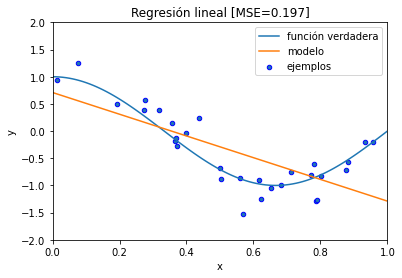

In [11]:
# represento la función verdadera, los ejemplos de entrenamiento y la predicción del modelo
fig, ax = plt.subplots()
ax.plot(X_test, fun(X_test), label="función verdadera")
ax.plot(X_test, y_pred, label="modelo")
ax.scatter(X_train, y_train, edgecolor="b", s=20, label="ejemplos")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim((0, 1))
ax.set_ylim((-2, 2))
ax.legend(loc="best")
titulo = "Regresión lineal [MSE={:0.3f}]".format(mse)
ax.set_title(titulo)
plt.show()

Aunque el ajuste de la regresión lineal es mejor que el que teníamos con el sistema media, podemos apreciar que la regresión lineal, al ser lineal, nunca podrá ajustarse correctamente a este conjunto de datos.

## 23.5 Regresión polinomial

Una solución que se plantea para estos casos es combinar de manera polinómica los atributos del conjunto de datos para posibilitar soluciones no lineales.

Esto es algo que no debería resultarnos desconocido puesto que ya lo vimos en la sesión dedicada al *kernel trick*.

En este caso, al no estar kernelizada la `LinearRegression` debemos generar esas combinaciones de los atributos de manera explícita utilizando el algoritmo `PolynomialFeatures`: 
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html?highlight=polynomialfea#sklearn.preprocessing.PolynomialFeatures 

En el parámetro `degree` debemos indicarle el grado que queremos aplicar y con el parámetro `include_bias` podemos decirle si queremos que los atributos se combinen también con el término independiente.

Vamos a ver los resultados que obtenemos, con esta **regresión polinomial**, aplicando distintos grados:

<Figure size 432x288 with 0 Axes>

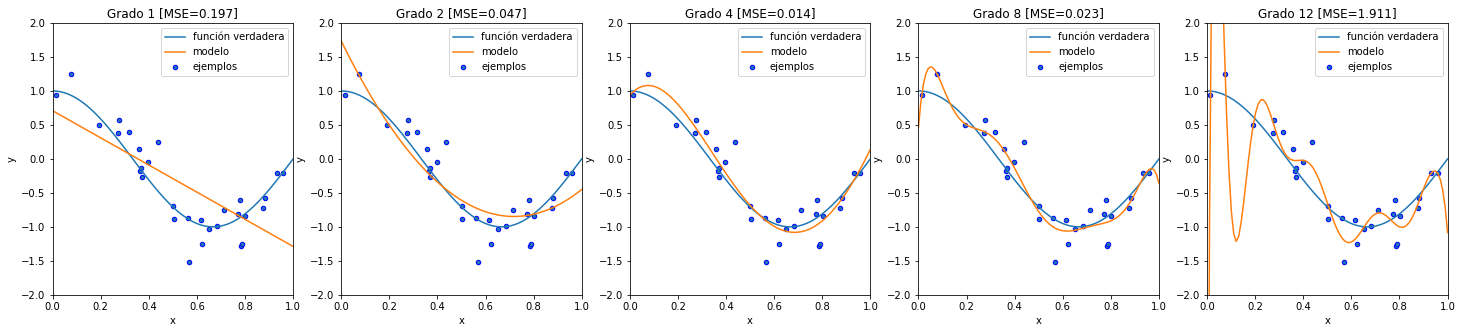

In [12]:
# creamos una figura con 4 gráficas
plt.figure()
fig, sub = plt.subplots(1, 5)
fig.set_size_inches(25, 5)

grados = [1, 2, 4, 8, 12]
for i in range(len(grados)):
    # se definen los atributos deseados en función del grado
    pf = PolynomialFeatures(degree=grados[i])

    # se crea el pipeline con regresión lineal
    sys_pf_linr = Pipeline([("pf", pf),("linr", LinearRegression())])

    # se entrena con el conjunto de entrenamiento (reshape es para darle ponerlo en forma (num_ejemplos_train,1))
    sys_pf_linr.fit(X_train.reshape(-1,1), y_train)

    # se evalúa sobre el conjunto de test (reshape es para darle ponerlo en forma (num_ejemplos_test,1))
    y_pred = sys_pf_linr.predict(X_test.reshape(-1,1))

    # se calcula el error cuadrático medio
    mse = metrics.mean_squared_error(y_test, y_pred)

    # mostramos el gráfico en el subplot correspondiente
    #plt.setp(sub[i], xticks=(), yticks=())  # quitamos los ticks
    sub[i].plot(X_test, fun(X_test), label="función verdadera")
    sub[i].plot(X_test, y_pred, label="modelo")
    sub[i].scatter(X_train, y_train, edgecolor="b", s=20, label="ejemplos")
    sub[i].set_xlabel("x")
    sub[i].set_ylabel("y")
    sub[i].set_xlim((0, 1))
    sub[i].set_ylim((-2, 2))
    sub[i].legend(loc="best")
    titulo = "Grado {:d} [MSE={:0.3f}]".format(grados[i], mse)
    sub[i].set_title(titulo)
plt.show()

Para utilizarlo hemos tenido que crear un `Pipeline` en el que primero se obtienen los atributos y posteriormente se calcula la regresión lineal.

Hemos probado con diferentes grados y en el título de cada gráfico podemos ver el MSE obtenido en cada caso.

Como vemos, a medida que aumentamos el grado corremos más riesgo de sobreajustarnos a los datos.

## 23.6 Regresión con regularización

En situaciones en las que queramos limitar la capacidad de sobreajuste de una regresión, podemos utilizar la regresión con regularización l2, que se implementa en el algoritmo `Ridge`: 

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html?highlight=ridge#sklearn.linear_model.Ridge

Mediante el hiperparámetro `alpha` podemos controlar el nivel de regularización que queremos. Con valor 0 indicamos que no queremos regularización y con valores mayores vamos aumentando la regularización y por tanto reduciendo el riesgo de sobreajuste.

Vamos a ver que pasa si fijamos el grado de `PolynomialFeatures` a 12, que vimos antes que se sobreajustaba mucho, y vamos aumentando el nivel de regularización aumentando poco a poco el valor de `alpha`:


##########################################
### efecto de alfa en Ridge
##########################################


<Figure size 432x288 with 0 Axes>

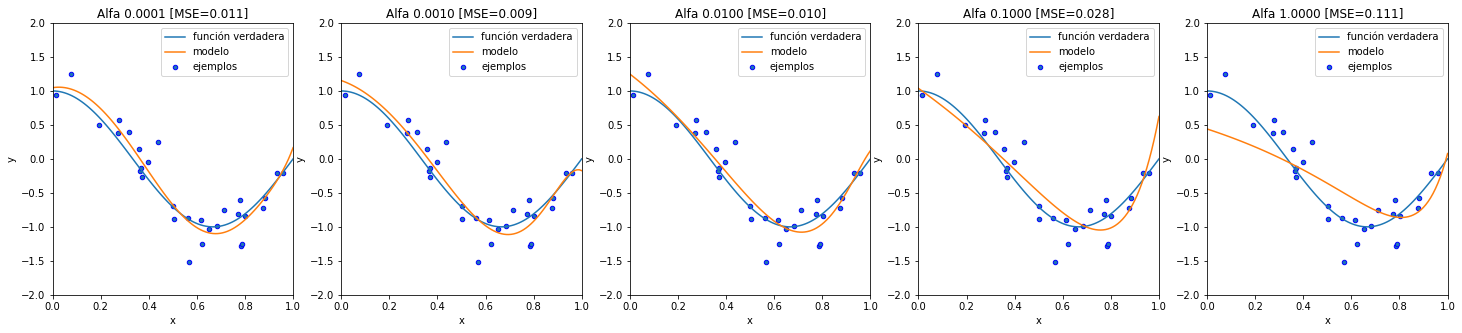

In [13]:
print('\n##########################################')
print('### efecto de alfa en Ridge')
print('##########################################')

# creamos una figura con 4 gráficas
plt.figure()
fig, sub = plt.subplots(1, 5)
fig.set_size_inches(25, 5)

alfas = [0.0001, 0.001, 0.01, 0.1, 1]
for i in range(len(alfas)):

    # se definen los atributos deseados en función del grado
    pf = PolynomialFeatures(degree=12)

    # se crea el pipeline con ridge
    sys_pf_linr = Pipeline([("pf", pf),("ridge", Ridge(alpha=alfas[i]))])

    # se entrena con el conjunto de entrenamiento (reshape es para darle ponerlo en forma (num_ejemplos,1))
    sys_pf_linr.fit(X_train.reshape(-1,1), y_train)

    # se evalúa sobre el conjunto de test (reshape es para darle ponerlo en forma (num_ejemplos,1))
    y_pred = sys_pf_linr.predict(X_test.reshape(-1,1))

    # se calcula el error cuadrático medio
    mse = metrics.mean_squared_error(y_test, y_pred)

    # mostramos el gráfico en el subplot correspondiente
    sub[i].plot(X_test, fun(X_test), label="función verdadera")
    sub[i].plot(X_test, y_pred, label="modelo")
    sub[i].scatter(X_train, y_train, edgecolor="b", s=20, label="ejemplos")
    sub[i].set_xlabel("x")
    sub[i].set_ylabel("y")
    sub[i].set_xlim((0, 1))
    sub[i].set_ylim((-2, 2))
    sub[i].legend(loc="best")
    titulo = "Alfa {:.4f} [MSE={:0.3f}]".format(alfas[i], mse)
    sub[i].set_title(titulo)
plt.show()

## Ejercicios

1. Carga los datos del fichero **housing.data**. 
2. Separa el conjunto de datos para hacer un hold out 80-20.
3. Evalúa los siguientes sistemas (con sus hiperparámetros por defecto) sobre esa partición: sistema media, regresión lineal (con y sin regularización) y regresión polinomial (con y sin regularización).
4. Muestra, en forma de tabla, los resultados de las tres métricas explicadas en el notebook.
5. Finalmente, calcula el error cuadrático medio que obtiene una regresión polinomial en una validación cruzada de 5 folds.

Estos ejercicios no es necesario entregarlos.